In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.applications import VGG16
import glob
import cv2

In [3]:
train_dir="C:/Users/DIBYAJYOTI HALOI/OneDrive/Desktop/summer project/mask folder/Train"
valid_dir="C:/Users/DIBYAJYOTI HALOI/OneDrive/Desktop/summer project/mask folder/Test"

In [6]:
img_width, img_height = 224, 224

In [7]:
conv_base = VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape=(img_width, img_height, 3))

# Show architecture
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
import os, shutil
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32


In [9]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))  # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count,2))
    # Preprocess data
    generator = datagen.flow_from_directory(directory,
                                            target_size=(img_width,img_height),
                                            batch_size = batch_size,
                                            class_mode='categorical')
    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
    
train_features, train_labels = extract_features(train_dir, 3103)  # Agree with our small dataset size
validation_features, validation_labels = extract_features(valid_dir, 1033)
# test_features, test_labels = extract_features(test_dir, test_size)

Found 3103 images belonging to 2 classes.
1/1 [==============================] - 6s 6s/step


C:\Users\DIBYAJYOTI HALOI\OneDrive\Documents\tempo\lib\site-packages\PIL\Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1/1 [==============================] - 1s 1s/step


In [10]:
train_labels

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]])

In [11]:
epochs = 150

model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=(7,7,512)))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 1026      
                                                                 
Total params: 1,026
Trainable params: 1,026
Non-trainable params: 0
_________________________________________________________________


In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')  

# Compile model
from keras.optimizers import Adam
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['acc'])

# Train model
history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size, 
                    callbacks=[checkpoint],
                    validation_data=(validation_features, validation_labels))

Epoch 1/150
94/97 [============================>.] - ETA: 0s - loss: 0.6685 - acc: 0.6626
Epoch 1: val_loss improved from inf to 0.53318, saving model to model-001-0.667741-0.849952.h5
97/97 [==============================] - 1s 6ms/step - loss: 0.6650 - acc: 0.6677 - val_loss: 0.5332 - val_acc: 0.8500
Epoch 2/150
88/97 [==========================>...] - ETA: 0s - loss: 0.4680 - acc: 0.8736
Epoch 2: val_loss improved from 0.53318 to 0.41700, saving model to model-002-0.872059-0.891578.h5
97/97 [==============================] - 0s 3ms/step - loss: 0.4664 - acc: 0.8721 - val_loss: 0.4170 - val_acc: 0.8916
Epoch 3/150
95/97 [============================>.] - ETA: 0s - loss: 0.3830 - acc: 0.8868
Epoch 3: val_loss improved from 0.41700 to 0.36442, saving model to model-003-0.886884-0.881897.h5
97/97 [==============================] - 0s 4ms/step - loss: 0.3822 - acc: 0.8869 - val_loss: 0.3644 - val_acc: 0.8819
Epoch 4/150
92/97 [===========================>..] - ETA: 0s - loss: 0.3384 - ac

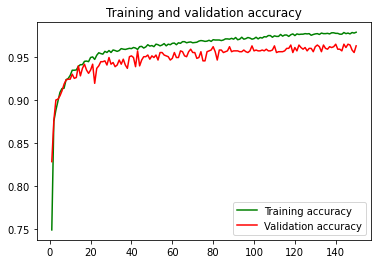

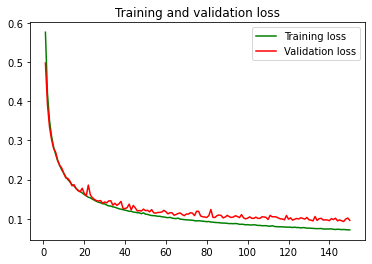

In [13]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
from keras.preprocessing import image
def prediction(img_path):
    org_img = image.load_img(img_path)
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
    img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application
    plt.imshow(org_img)                           
    plt.axis('off')
    plt.show()


    # Extract features
    features = conv_base.predict(img_tensor.reshape(1,img_width, img_height, 3))

    # Make prediction
    try:
        prediction = model.predict(features)
    except:
        prediction = model.predict(features.reshape(1, 7*7*512))
        
    classes = ["with_mask","without_mask"]
    print("I see..."+str(classes[np.argmax(np.array(prediction[0]))]))
pred_dir = "/kaggle/input/intel-image-classification/seg_pred/seg_pred/"

In [14]:
pred_dir = ""
import random
pred_files = random.sample(os.listdir(pred_dir),10)
for f in pred_files:
    prediction(pred_dir+f)

FileNotFoundError: [WinError 3] The system cannot find the path specified: ''